In [1]:
# UPDATE THIS PATH WITH THE PATH FOR THE CIFAR-10 dataset files.

CIFAR_10_ROOT = 'data/'

# Classification of CIFAR-10 Dataset using Convolutional Neural Network

Import the dependencies.

In [2]:
from os import path
import pickle

# Numpy and matplotlib.
import numpy as np
import matplotlib.pyplot as plt
import torch

Before we move on, we want to check if CUDA is available for GPU computation. If so, we always prefer to use GPU.

In [3]:
gpu_enable = torch.cuda.is_available()
device = torch.device('cuda' if gpu_enable else 'cpu')
device

device(type='cuda')

## Data Loader

Our dataset is composed of images, each of size $32 \times 32$ and composed of three channels (R, G, B). There are 5 files corresponding to different training batches, each file containing 10000 images, along with their labels. There are 10 different labels.

We can represent a training batch using four dimensions: $(B, C, H, W)$ where $B$ is the batch size, $C$ is the channel, $H$ is the image row, and $W$ is the image column. If we have 10000 datapoints in a training batch, then the size of the training batch is $10000 \times 3 \times 32 \times 32$.

Besides the training datasets, there is also a file containing 10000 images to use for testing. However, we will choose to use 5000 of these as validation set and 5000 as test set. The validation set will be used to select the best model during training and the test set will be used to report final accuracy of the model.

We could compute the overall mean and standard deviation of the training set and use that for the normalizing all of the training, test and validation sets. However, the mean and standard deviation for the CIFAR-10 training datasets is already available from the source as follows:

In [4]:
# One value for each channel (R, G, B).
# The following values is computed assuming that the image intensities are in the range (0, 1).
TRAINING_MEAN = np.array([0.4914, 0.4822, 0.4465])
TRAINING_STD_DEV = np.array([0.2023, 0.1994, 0.2010])

Next we will use a class to organize the data loader.

In [30]:
class CIFAR10:
    # Let's reshape the mean and std to the same shapes and type as our training and test datasets.
    MEAN = TRAINING_MEAN.reshape(1, 3, 1, 1).astype('float32')
    STD_DEV = TRAINING_STD_DEV.reshape(1, 3, 1, 1).astype('float32')
    
    def __init__(self, root_path):
        """
        root_path: Folder which contains the CIFAR-10 dataset files.
        """
        self.root = root_path
        
    def load_single_file(self, filename):
        """
        Load all 10000 images and their labels from a single file.
        filename: File from which to load the images and their labels.
        
        returns: (X, Y) where X is the image dataset of size 10000x3x32x32
                        and Y is an array of corresponding labels.
        """
        
        # Use pickle to load the dataset. The file is in the `root` folder.
        filename = path.join(self.root, filename)
        with open(filename, 'rb') as f:
            datadict = pickle.load(f, encoding ='bytes')
            
            # X and Y
            X = datadict[b'data']
            Y = datadict[b'labels']
            
            # Reshape X to (B, C, H, W) as described above.
            X = X.reshape(10000, 3, 32, 32).astype('float32')
            
            # Normalize using the training mean and stdandard deviation.
            # Note that we need to transform the image intensities to range (0, 1)
            # before using the above values for mean and std_dev.
            X = (X / 255.0 - CIFAR10.MEAN) / CIFAR10.STD_DEV
            
            # Make sure Y is numpy array before we can use it.
            Y = np.array(Y)
            
            # Let's return X and Y but as pytorch tensors.
            return (
                torch.as_tensor(X, device=device),
                torch.as_tensor(Y, device=device),
            )
        
    def iter_training_set(self, batch_size=100):
        """
        Generator to yield a training set of given batch size.
        Each time, each batch is generated randomly.

        batch_size: Maximum size of each training batch.
        """

        # There are 6 different files for the training sets.
        # Load them in random order.
        file_indices = list(range(1, 6))
        np.random.shuffle(file_indices)

        for file_index in file_indices:
            filename = f'data_batch_{file_index}'

            # Load the 10000 images and their labels.
            X_all, Y_all = self.load_single_file(filename)

            # Let's shuffle these samples as well.
            num_samples = len(X_all)
            all_indices = list(range(num_samples))
            np.random.shuffle(all_indices)

            # And yield each batch of given batch_size
            for i in range(0, num_samples, batch_size):
                # Select the batch indices:
                indices = torch.LongTensor(
                    all_indices[i: i + batch_size]
                )
                if gpu_enable:
                    indices = indices.cuda()

                yield (
                    X_all.index_select(0, indices),
                    Y_all.index_select(0, indices),
                )

    def load_validation_and_test_sets(self, validation_size=5000):
        """
        Load the validation and test sets.
        """
        X_all, Y_all = self.load_single_file('test_batch')
        return (
            X_all[:validation_size], Y_all[:validation_size],
            X_all[validation_size:], Y_all[validation_size:]
        )
            

## Neural Network Layers

In [64]:
class Layer:
    """
    Each layer requires at least a `forward` function and a list of parameters that need to be trained.
    """
    
    # Params that need to be trained during gradient descent.
    params = []

    def forward(self, X):
        """
        Takes input X and return an output.
        """
        raise NotImplemented
        
    def restore(self, params):
        pass
        

Before we move on, here's a simple utility function to generate a tensor of random values from a uniform distribution of a given range.

In [65]:
def uniform(a, b, size, requires_grad=False):
    # Idea is to first create an empty tensor of given size.
    t = torch.empty(size=size, device=device)
    # Then fill in the values from the uniform distribution.
    t.uniform_(a, b)
        
    # Finally, if this tensor requires gradient, then do so.
    return t.requires_grad_(requires_grad)

### Linear Layer

A linear layer is simply the linear calculation of the form: $Z = WX + b$, where $Z$ is the output, $W$ is the weight matrix and $b$ is the input.

We will use Xavier initialization with random uniform distribution to initialize the weights and bias:
$U [-\sqrt{k}, \sqrt{k}]$ where $k = \frac{1}{n_i}$, $n_i = \text{number of input neurons}$.

In [66]:
class LinearLayer(Layer):
    def __init__(self, num_inputs, num_outputs):
        """
        num_inputs: Number of input neurons to this layer.
        num_outputs: Number of output neurons of this layer.
        """
        
        # Simply initialize the W and b matrices.
        k = np.sqrt(1 / num_inputs)
        self.w = uniform(-k, k, size=(num_inputs, num_outputs), requires_grad=True)
        self.b = uniform(-k, k, size=(num_outputs,), requires_grad=True)
        
        # Parameters to be trained.
        self.params = [self.w, self.b]
        
    def forward(self, x):
        # In forward, simply calculate WX + b
        return torch.matmul(x, self.w) + self.b
    
    def restore(self, params):
        self.w, self.b = params
        self.params = params

### Convolutional Layer

This is similar to Linear Layer, except that instead of calculating $WX$ we calculate $W * X$ where $*$ stands for convolution and $W$ is a rectangular kernel.

Unlike the Linear Layer, the convolutional layer cana actually accept inputs of multiple channels and generate outputs of multiple channels. The number of output channels is equal to the number of filters used in this layer.

In [67]:
class ConvLayer(Layer):
    def __init__(self, filter_size, in_channels, out_channels, stride=1, padding=0):
        """
        filter_size: Size of the kernel. We assume the kernel is square.
        in_channels: Number of input channels.
        out_channels: Number of output channels, corresponding to the number of filters to use.
        stride, padding: Stride and padding to use with the convolutional operator.
        """
        
        # Intialize these similar to the linear layer.
        k = np.sqrt(1 / (in_channels * filter_size * filter_size))
        self.w = uniform(-k, k, size=(out_channels, in_channels, filter_size, filter_size), requires_grad=True)
        self.b = uniform(-k, k, size=(out_channels,), requires_grad=True)
        
        self.stride = stride
        self.padding = padding
        
        # Parameters to be trained.
        self.params = [self.w, self.b]
        
    def forward(self, x):
        # We use the convolution function from pytorch to calculate convolution.
        return torch.nn.functional.conv2d(x, self.w, bias=self.b,
                                         stride=self.stride,
                                         padding=self.padding)
    
    def restore(self, params):
        self.w, self.b = params
        self.params = params

### Pooling Layer

Max pooling is a simple operation that reduces the size of the input images. We can do it manually by scanning the image or we can simply use the pytorch function to do so.

In [68]:
class MaxPool(Layer):
    def __init__(self, size, stride=2):
        self.size = size
        self.stride = stride
        
    def forward(self, x):
        return torch.nn.functional.max_pool2d(x, self.size, self.stride)

# Following is how we can implement the max_pool ourselves. This is slower than pytorch implementation though.
#         x = x\
#             .unfold(2, self.size, self.stride)\
#             .unfold(3, self.size, self.stride)
#         return torch.max(torch.max(x, -1)[0], -1)[0]

### Activation Layer

We can use Relu or Sigmoid for activations, which are implemented pretty simply as follows.

In [69]:
class Relu(Layer):
    def forward(self, x):
        return torch.nn.functional.relu(x)
        # return torch.max(input=x, other=torch.tensor(0.0, device=device))

In [70]:
class Sigmoid(Layer):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

### Flattening Layer

We use this layer to convert the outputs of convolutional and max-pooling layers into a long flattened arrays that we can use with the linear layers.

In [71]:
class Flatten(Layer):
    def forward(self, x):
        # Flattening is pretty straightforward using pytorch's view function.
        return x.view((x.shape[0], -1))

## Neural Network Architecture

Now that we have the layers as the building blocks, we can build a deep neural network architecture.

For classifying the CIFAR-10 datatsets, we have decided to use an architecture based on **VGG-11**. The architecture consists of following configuration:

```
Conv(3x3, 64 filters) => ReLu => MaxPool =>
Conv(3x3, 128 filters) => ReLu => MaxPool =>
Conv(3x3, 256 filters) => ReLu => Conv(3x3 256 filters) => ReLu => MaxPool =>
Conv(3x3, 512 filters) => ReLu => Conv(3x3 512 filters) => ReLu => MaxPool =>
Conv(3x3, 512 filters) => ReLu => Conv(3x3 512 filters) => ReLu => MaxPool =>
Flatten => Dense Linear Layer (512 inputs, 10 outputs)
```

Our neural network is then simply a list of these layers in sequence. We can set it up as follows.

In [88]:
layers = [
    ConvLayer(3, 3, 64, padding=1),
    Relu(),
    MaxPool(2, 2),
    
    ConvLayer(3, 64, 128, padding=1),
    Relu(),
    MaxPool(2, 2),
    
    ConvLayer(3, 128, 256, padding=1),
    Relu(),
    ConvLayer(3, 256, 256, padding=1),
    Relu(),
    MaxPool(2, 2),
    
    ConvLayer(3, 256, 512, padding=1),
    Relu(),
    ConvLayer(3, 512, 512, padding=1),
    Relu(),
    MaxPool(2, 2),
    
    ConvLayer(3, 512, 512, padding=1),
    Relu(),
    ConvLayer(3, 512, 512, padding=1),
    Relu(),
    MaxPool(2, 2),
    
    Flatten(),
    LinearLayer(512, 10)
]

In [89]:
def net(x):
    """
    The FORWARD path for the neural network:
    
    x: Input to the neural network
    """
    
    # Simply, "feed-forward" to each layer.
    tmp = x
    for layer in layers:
        tmp = layer.forward(tmp)
    return tmp

## Training and Validation

To train using an optimization algorithm, we need to define the error or loss function. Since this is a multiclass classification, an appropriate loss function is **Cross Entropy**.

Note that Cross Entropy is based on probability and for multiclass neural network, we can use Softmax to convert the output of the neural nework into probabilities. However, the pytorch's cross entropy loss function automatically handles this conversion for us.

In [90]:
loss = torch.nn.CrossEntropyLoss()

**Accuracy** is defined as the percentage of correct classifications.

In [91]:
def accuracy(y, y_true):
    """
    The prediction of our neural network for any image
    is a one-hot encoded vector,
    where the index of `1` in the vector represents the label.
    If we have a batch of images, we have a matrix of such vectors.
    
    y: Matrix of predicted labels as one hot encoded vectors.
    y_true: Array of true labels (NOT on hot encoded).
    """
    
    # Calculate the labels from one-hot encoded vectors.
    y = y.argmax(dim=1)
    # Check how many of them match the true labels.
    acc = (y == y_true).float().sum().cpu()
    
    # Return the ratio.
    return acc.item() / len(y_true)

Let's set some initial variables before we start the training.

In [92]:
# Learning rate = 0.01
lr = 0.01

# Batch size = 128
batch_size = 128

# Number of traning epochs
max_epochs = 20

# The parameters of the neural network that needs to be trained.
params = []
for layer in layers:
    for param in layer.params:
        params.append(param)
    
    
# The optimization function to use for training.
optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9)

Use the data loader to load the test and validation sets.

In [93]:
data_loader = CIFAR10(CIFAR_10_ROOT)
valid_x, valid_y, test_x, test_y = data_loader.load_validation_and_test_sets()

Perform the actual training. 

In [94]:
training_errors = []
valid_errors = []
param_states = []


def record_param_state():
    state = []
    for layer in layers:
        state.append([param.clone() for param in layer.params])
    return state
        
def restore_param_state(state):
    for i, layer in enumerate(layers):
        layer.restore(state[i])

        
# For each epoch:
for epoch in range(max_epochs):
    
    print(f'Epoch: {epoch + 1}')
    
    training_error = 0
    training_size = 0
    
    # Get each bach:
    for x, y in data_loader.iter_training_set(batch_size):
        # Zero out the gradients.
        optimizer.zero_grad()
        
        # Feed input to the neural network.
        y_dash = net(x)
        
        # Calculate loss.
        l = loss(y_dash, y)
        
        # Backpropagate loss.
        l.backward()
        
        # Use gradient descent to update the parameters.
        optimizer.step()
        
        training_error += 1 - accuracy(y_dash, y)
        training_size += len(x)
        
    # Training error for the last batch in this epoch.
    training_errors.append(training_error / training_size)
    
    # Validation error.
    valid_errors.append(
        1 - accuracy(net(valid_x), valid_y)
    )
    
    param_states.append(
        record_param_state()
    )
    
print('\nDONE')

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20

DONE


Plot the training and validation errors.

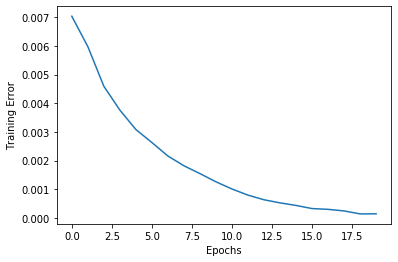

In [95]:
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.plot(training_errors)

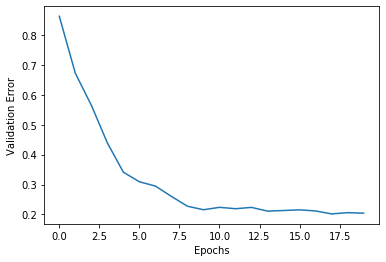

In [96]:
plt.xlabel('Epochs')
plt.ylabel('Validation Error')
plt.plot(valid_errors)

We select the final model parameters that gave the minimum validation error.

In [100]:
desired_epoch = np.argmin(valid_errors)
desired_state = param_states[desired_epoch]
restore_param_state(desired_state)

# Final Accuracy

Final accuracy is based on the test dataset.

In [101]:
acc = accuracy(net(test_x), test_y) * 100
print(f'Accuracy: {acc:.2f}%')

Accuracy: 79.74%
